# Modelos de Aprendizado de Máquina
Neste notebook tem os seguintes modelos de aprendizado de máquina comparados:
- Floresta Aleatória
- SVM

## Importações

In [3]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

# Other
from IPython.display import Image
import warnings
import pprint
import datetime
import os

## Preparação do Diretório Principal

In [4]:
def prepare_directory_work(end_directory: str='notebooks'):
    # Current path
    curr_dir = os.path.dirname (os.path.realpath ("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return curr_dir
    
    return f'Current working directory: {curr_dir}' 

In [5]:
prepare_directory_work(end_directory='notebooks')

'/home/campos/projects/tcc-ufsc-grad/notebooks'

## Formatação das células

In [6]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# Guarantees visualization inside the jupyter
%matplotlib inline

# Print xxxx rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

# pretty print
pp = pprint.PrettyPrinter(indent=4)

In [7]:
plt.style.use('seaborn')  # fivethirtyeight
plt.rc('figure',figsize=(16,8))
plt.rc('font',size=15)
plt.rc('legend',fontsize=15)

# Seaborn rcParams
# ===================
sns.set(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

# graph style
sns.set(style='dark', palette='deep')

plt.style.use('fivethirtyeight')

## Carregamento dos Dados

In [8]:
%%time

df_vale3 = pd.read_csv('data/cleansing/df_vale3_cleansing.csv',
                        encoding='utf8',
                        delimiter=',',
                        parse_dates=True,
                        index_col=0,
                        verbose=True)

Tokenization took: 4.51 ms
Type conversion took: 4.05 ms
Parser memory cleanup took: 0.01 ms
CPU times: user 19.3 ms, sys: 0 ns, total: 19.3 ms
Wall time: 26.2 ms


In [9]:
print(df_vale3.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2445 entries, 2010-07-12 to 2020-05-28
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   preco         2445 non-null   float64
 1   residuos      2445 non-null   float64
 2   tendencia     2445 non-null   float64
 3   sazonalidade  2445 non-null   float64
 4   diff_1        2445 non-null   float64
 5   diff_2        2445 non-null   float64
 6   diff_3        2445 non-null   float64
 7   diff_4        2445 non-null   float64
 8   diff_5        2445 non-null   float64
dtypes: float64(9)
memory usage: 191.0 KB
None


In [10]:
df_vale3.head()

,preco,residuos,tendencia,sazonalidade,diff_1,diff_2,diff_3,diff_4,diff_5
data,,,,,,,,,
2010-07-12,40.000000,1.002310,41.827333,1.000149,-0.600000,-0.460000,0.490000,0.980000,0.420000
2010-07-13,40.070000,1.036654,41.910833,0.998563,0.070000,-0.530000,-0.390000,0.560000,1.050000
2010-07-14,40.080000,1.028377,41.977833,1.000439,0.010000,0.080000,-0.520000,-0.380000,0.570000
2010-07-15,39.760000,1.044658,42.045833,1.000935,-0.320000,-0.310000,-0.240000,-0.840000,-0.700000
2010-07-16,38.880000,1.028132,42.123500,1.001784,-0.880000,-1.200000,-1.190000,-1.120000,-1.720000


---

## Divisão dos Dados

In [11]:
size_train = 2355
size_test = 90
print(size_train)
print(size_test)

df_train = df_vale3.iloc[:size_train]
df_test = df_vale3.iloc[size_train:]
print(df_train.columns)
print(df_test.columns)

2355
90
Index(['preco', 'residuos', 'tendencia', 'sazonalidade', 'diff_1', 'diff_2',
       'diff_3', 'diff_4', 'diff_5'],
      dtype='object')
Index(['preco', 'residuos', 'tendencia', 'sazonalidade', 'diff_1', 'diff_2',
       'diff_3', 'diff_4', 'diff_5'],
      dtype='object')


In [12]:
df_vale3_without_target = df_train.columns
df_vale3_without_target = df_vale3_without_target.drop('preco')

print(df_vale3_without_target)

Index(['residuos', 'tendencia', 'sazonalidade', 'diff_1', 'diff_2', 'diff_3',
       'diff_4', 'diff_5'],
      dtype='object')


Text(0.5, 1.0, 'Train size: 2355')

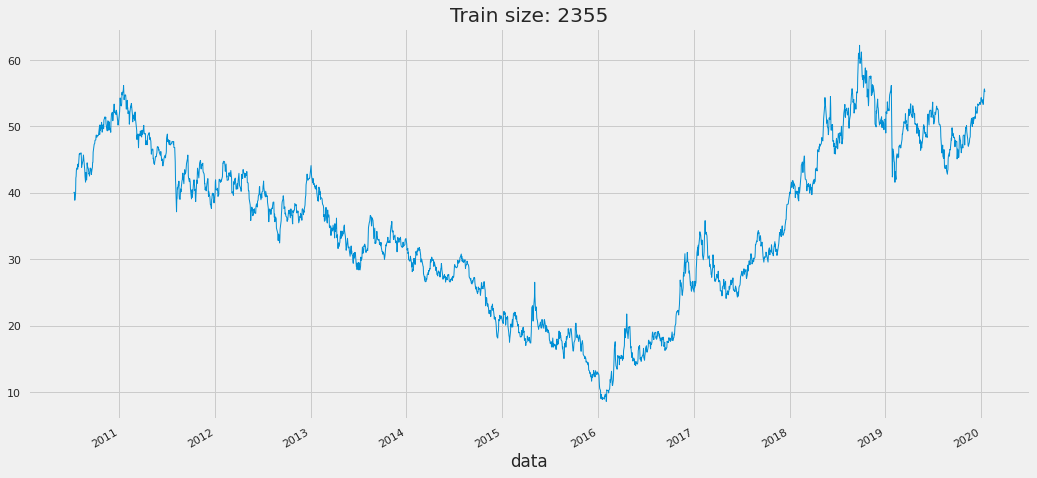

In [13]:
df_train['preco'].plot(linewidth=1)
plt.grid(True)
plt.title(f'Train size: {len(df_train)}')

Text(0.5, 1.0, 'Test size: 90')

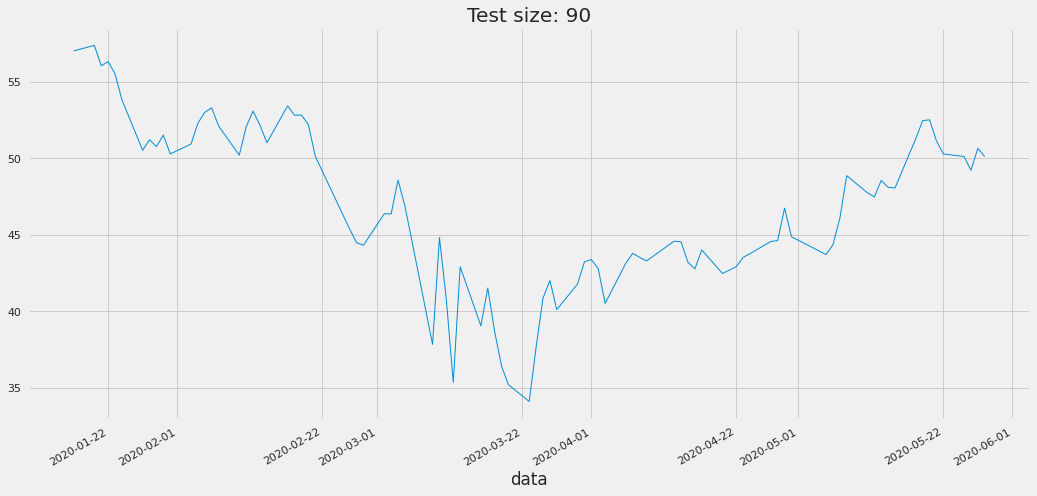

In [14]:
df_test['preco'].plot(linewidth=1)
plt.grid(True)
plt.title(f'Test size: {len(df_test)}')

In [15]:
df_train.index

DatetimeIndex(['2010-07-12', '2010-07-13', '2010-07-14', '2010-07-15',
               '2010-07-16', '2010-07-19', '2010-07-20', '2010-07-21',
               '2010-07-22', '2010-07-23',
               ...
               '2020-01-03', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-13', '2020-01-14',
               '2020-01-15', '2020-01-16'],
              dtype='datetime64[ns]', name='data', length=2355, freq=None)

In [16]:
df_test.index

DatetimeIndex(['2020-01-17', '2020-01-20', '2020-01-21', '2020-01-22',
               '2020-01-23', '2020-01-24', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-03',
               '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07',
               '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-17', '2020-02-18', '2020-02-19',
               '2020-02-20', '2020-02-21', '2020-02-26', '2020-02-27',
               '2020-02-28', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-09', '2020-03-10',
               '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26',
               '2020-03-27', '2020-03-30', '2020-03-31', '2020-04-01',
               '2020-04-02', '2020-04-03', '2020-04-06', '2020-04-07',
      

In [17]:
X_train = df_train[df_vale3_without_target]
y_train = df_train['preco']
print(len(X_train))
print(len(y_train))
print(type(X_train))
print(type(y_train))
print((X_train[:5]))
print(y_train[:5])

2355
2355
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
            residuos  tendencia  sazonalidade    diff_1    diff_2    diff_3  \
data                                                                          
2010-07-12  1.002310  41.827333      1.000149 -0.600000 -0.460000  0.490000   
2010-07-13  1.036654  41.910833      0.998563  0.070000 -0.530000 -0.390000   
2010-07-14  1.028377  41.977833      1.000439  0.010000  0.080000 -0.520000   
2010-07-15  1.044658  42.045833      1.000935 -0.320000 -0.310000 -0.240000   
2010-07-16  1.028132  42.123500      1.001784 -0.880000 -1.200000 -1.190000   

              diff_4    diff_5  
data                            
2010-07-12  0.980000  0.420000  
2010-07-13  0.560000  1.050000  
2010-07-14 -0.380000  0.570000  
2010-07-15 -0.840000 -0.700000  
2010-07-16 -1.120000 -1.720000  
data
2010-07-12   40.000000
2010-07-13   40.070000
2010-07-14   40.080000
2010-07-15   39.760000
2010-07-16   38.880000
Name: preco

In [18]:
X_test = df_test[df_vale3_without_target]
y_test = df_test['preco']
print(len(X_test))
print(len(y_test))
print(type(X_test))
print(type(y_test))
print(X_test[:5])
print(y_test[:5])

90
90
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
            residuos  tendencia  sazonalidade    diff_1    diff_2    diff_3  \
data                                                                          
2020-01-17  1.002320  53.689833      0.999907  1.830000  1.540000  1.360000   
2020-01-20  1.003903  53.618833      1.000522  0.360000  2.190000  1.900000   
2020-01-21  1.002369  53.539833      1.002512 -1.330000 -0.970000  0.860000   
2020-01-22  0.993027  53.510167      1.003050  0.270000 -1.060000 -0.700000   
2020-01-23  1.008381  53.469833      1.000677 -0.800000 -0.530000 -1.860000   

              diff_4   diff_5  
data                           
2020-01-17  1.700000 3.640000  
2020-01-20  1.720000 2.060000  
2020-01-21  0.570000 0.390000  
2020-01-22  1.130000 0.840000  
2020-01-23 -1.500000 0.330000  
data
2020-01-17   57.000000
2020-01-20   57.360000
2020-01-21   56.030000
2020-01-22   56.300000
2020-01-23   55.500000
Name: preco, dtype: fl

---

## Dicionário de Resultados

In [19]:
dict_results = {}

---

## Impressão dos Resutados

In [20]:
def show_result_model(df_train, df_test, y_forecast, model_name):
    future_forecast = pd.DataFrame(y_forecast,
                                   index=df_test.index,
                                   columns=['previsao'])
    #mape = mean_absolute_percentage_error(df_test, y_forecast)
    mape = mean_absolute_percentage_error(df_test, y_forecast)*100
    
    mse = mean_squared_error(df_test, y_forecast, squared=True)
    dict_results[model_name] = [mape, mse]
    
    pd.concat([df_test, future_forecast], axis=1).plot()

    plt.legend()
    plt.grid(True)
    plt.xlabel("Tempo (dias)", fontsize=20)
    plt.ylabel("Preço (R$)", fontsize=20)
    plt.title(f'MAPE = {mape:.2f} % | MSE = {mse:.2f}', fontsize=25)

---

## Floresta Aleatória

In [251]:
# RandomForest params dict
rf_params_one = {}
rf_params_one['criterion'] = 'mse'
rf_params_one['n_estimators'] = 1000
rf_params_one['max_depth'] = 3
rf_params_one['random_state'] = 0
rf_params_one['n_jobs'] = -1 # run all process

In [252]:
model_rf_regressor = RandomForestRegressor(**rf_params_one)
model_rf_regressor

RandomForestRegressor(max_depth=3, n_estimators=1000, n_jobs=-1, random_state=0)

In [253]:
model_rf_regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=1000, n_jobs=-1, random_state=0)

In [254]:
y_pred_rf_regressor = model_rf_regressor.predict(X_test)
y_pred_rf_regressor[:5]

array([52.8786186, 52.8786186, 52.8786186, 52.8786186, 52.8786186])

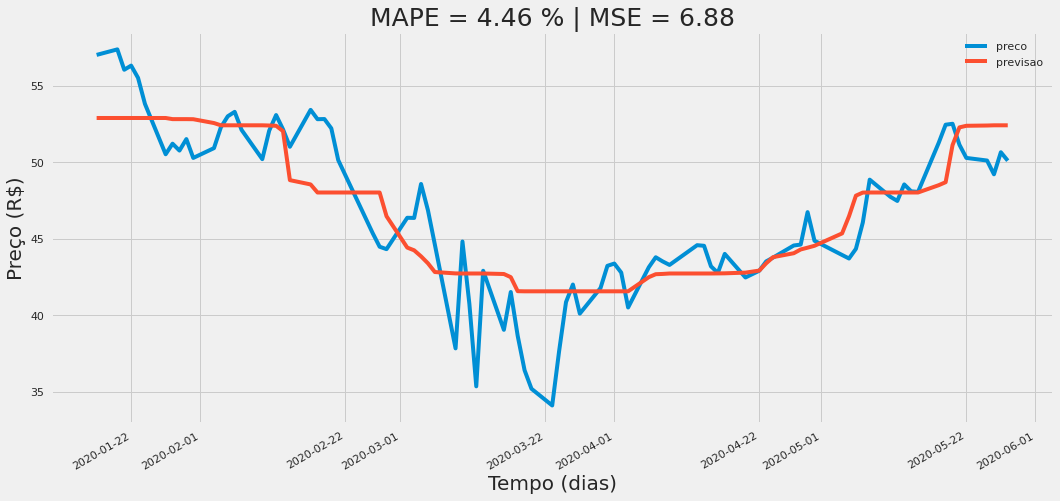

In [255]:
show_result_model(df_train=y_train,
                  df_test=y_test, 
                  y_forecast=y_pred_rf_regressor,
                  model_name='model_rf_regressor')

---

### SVM
- Doc sobre gamma: https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
- Gamma é quem controla o learning rate

In [143]:
model_svm_regressor = SVR(kernel='rbf', gamma= 0.05)
model_svm_regressor

SVR(gamma=0.05)

In [144]:
model_svm_regressor.fit(X_train, y_train)

SVR(gamma=0.05)

In [145]:
y_pred_svm_regressor = model_svm_regressor.predict(X_test)
y_pred_svm_regressor[:5]

array([52.65658285, 54.58178962, 52.4233238 , 52.56122228, 52.53185728])

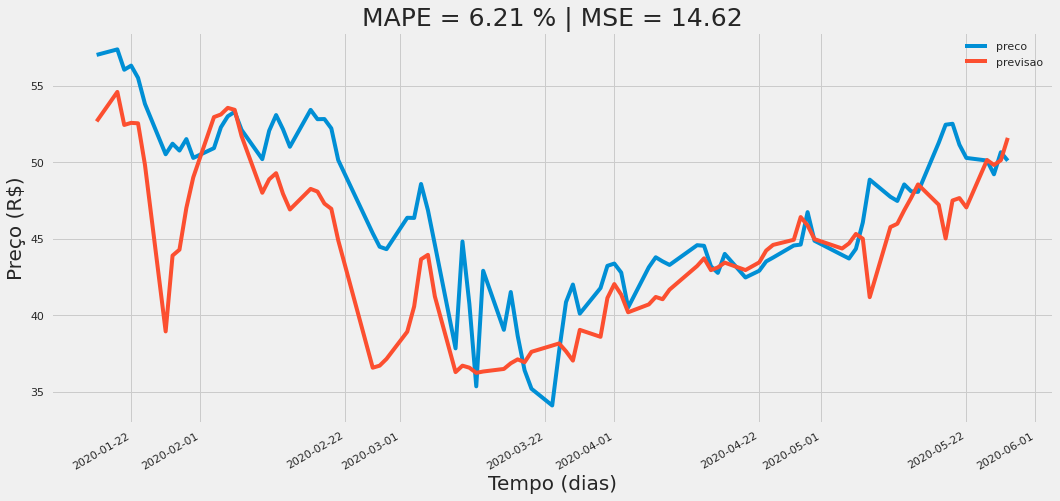

In [146]:
show_result_model(df_train=y_train,
                  df_test=y_test, 
                  y_forecast=y_pred_svm_regressor,
                  model_name='model_svm_regressor')

#### Zoom

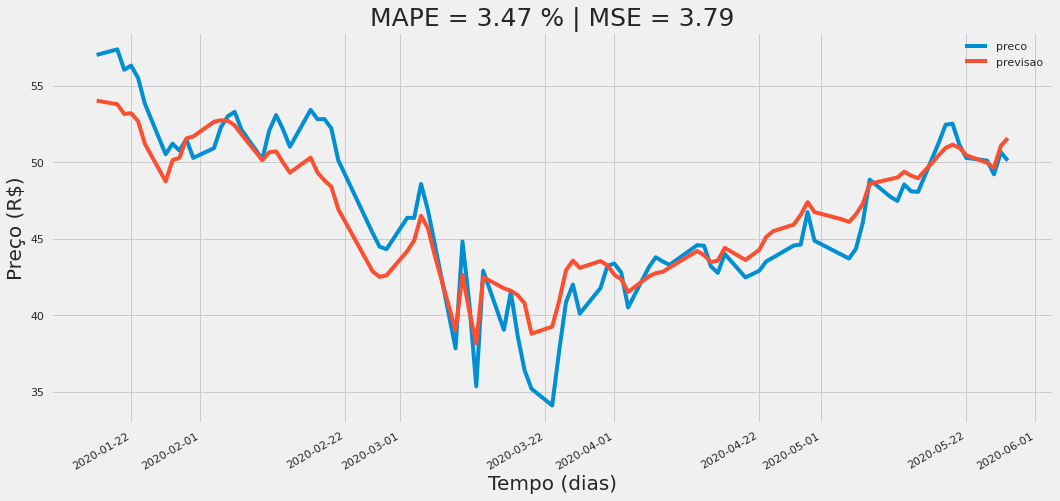

In [31]:
show_result_model(df_train=y_test,
                  df_test=y_test, 
                  y_forecast=y_pred_svm_regressor,
                  model_name='model_svm_regressor')

---

## Results

In [32]:
dict_results

{'model_rf_regressor': [4.4631149103943235, 6.8802699340655575],
 'model_svm_regressor': [3.4671352417623735, 3.7876629834209408]}

---